In [4]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 


In [5]:
Y=np.load('tomatoes.npy') # Make sure you downloaded this file from Learn!
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

Length of data: 30
Data:
[13.27597167 15.08565281 13.41061844 11.5510474  10.63232069 13.76932811
 10.31644803 14.55388057 12.57937117 14.13647951 15.37354413  9.96525246
 12.66541964 11.33164599 12.14113179 11.57753389 15.86128067 10.23999543
 16.36971379 13.96021609 17.27321719 12.23476479 17.96792692 13.92888826
 10.64602864 16.45922776 15.56009798 13.02118014 16.50556431 14.08484862]


In [10]:
def U(q,y):
    m1,m2,m3 = q 
    
    n = len(y)
    p_prior = np.exp(-(13.5-m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    log_prior = np.log(p_prior)
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    log_p_hat = np.log(p_hat)
    V = -log_prior - sum(log_p_hat)
    
    return V

In [11]:
def run_simulation_with_data( q0,p0, Nsteps, h, gamma, step_function, force_function, Y):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, h, Y)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [26]:
def force(q,y):
    m1,m2,m3 = q  
    
    n = len(y)
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y-m1_vec)**2/2) + np.exp(-(y-m2_vec)**2/2) + np.exp(-(y-m3_vec)**2/2)
    
    # Take the negative of each gradient
    grad_m1 = -(-(1/16)*(13.5 - m1) + sum(-(y - m1_vec)*np.exp(-(y - m1_vec)**2/2)/p_hat))
    grad_m2 = -(-(1/16)*(13.5 - m2) + sum(-(y - m2_vec)*np.exp(-(y - m2_vec)**2/2)/p_hat))
    grad_m3 = -(-(1/16)*(13.5 - m3) + sum(-(y - m3_vec)*np.exp(-(y - m3_vec)**2/2)/p_hat))
    
    return grad_m1,grad_m2,grad_m3
    

(-11.386420021143474, -4.188324781955538, 12.360380829908367)

In [13]:
def HMC_with_data(q0,h,y):
    q = q0
    p = np.random.randn(3)
    current_p = p
    
    p = p + h*np.asarray(force(q,y))/2
    q = q + h*p
    p = p + h*np.asarray(force(q,y))/2
    p = -p
    
    current_U = U(q0,y)
    current_K = sum(current_p**2)/2
    proposed_U = U(q, y)
    proposed_K = sum(p**2)/2
    
    accept = -1
    if np.random.uniform(0,1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        accept = 1
        return q, accept      # accept
    else:
        accept = 0
        return q0, accept     # reject
    
 

In [14]:

q0 = np.random.randn(3) + 13   # initialise q0 to be close to the mean (of tomato mass)
p0 = np.random.randn(3)

.2*np.asarray(force(q0,Y))/2


array([-1.138642  , -0.41883248,  1.23603808])

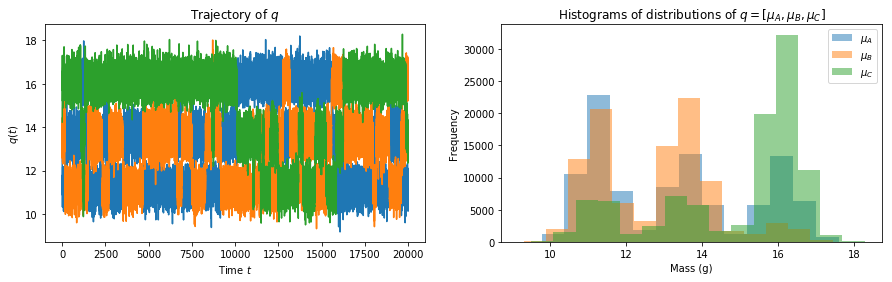

In [15]:
Nsteps = 100000
h = 0.2
gamma = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation_with_data(q0, p0, Nsteps , h, gamma, HMC_with_data, force, Y)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

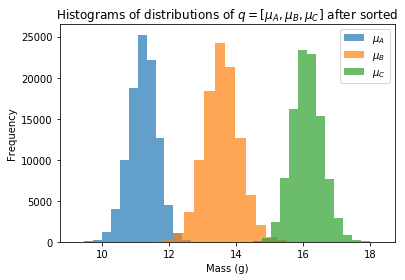

In [16]:

n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 13.5, which is roughly the middle of the data.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(13.5-\mu_A)^2/32}) \exp({-(13.5-\mu_B)^2/32}) \exp({-(13.5-\mu_B)^2/32}) $$

In [34]:
# Minibatch size: n

def get_minibatch(y,n):
    # x must be an array
    np.random.shuffle(y)
    batch = y[0:n-1]
    y = y[n:]
    return batch, y
    

def force_noise(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    m1_vec = m1*np.ones(n)
    m2_vec = m2*np.ones(n)
    m3_vec = m3*np.ones(n)
    p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
    
    
    # Take the negative of each gradient
    grad_m1 = -(-(1/16)*(13.5 - m1) + batch_scaling*sum(-(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat))  
    grad_m2 = -(-(1/16)*(13.5 - m2) + batch_scaling*sum(-(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat))
    grad_m3 = -(-(1/16)*(13.5 - m3) + batch_scaling*sum(-(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat))
    
    return grad_m1,grad_m2,grad_m3


def HMC_with_noise(q0,h,y,n):
    # n is the size of the batch
    batch_scaling = len(y)/n
    q = q0
    p = np.random.randn(3)
    current_p = p
    
    y_batch, y_updated = get_minibatch(y,n)
    
    p = p + h*np.asarray(force_noise(q,y_batch,batch_scaling))/2
    q = q + h*p
    p = p + h*np.asarray(force_noise(q,y_batch,batch_scaling))/2
    p = -p
    
    current_U = U(q0,y)
    current_K = sum(current_p**2)/2
    proposed_U = U(q, y)
    proposed_K = sum(p**2)/2
    
    accept = -1
    if np.random.uniform(0,1) < np.exp(current_U - proposed_U + current_K - proposed_K):
        accept = 1
        return q, accept,y_updated      # accept
    else:
        accept = 0
        return q0, accept, y_updated     # reject
    

In [35]:
y_batch, y = get_minibatch(Y,5)
y_batch
grad1,grad2,grad3 = force_noise(q0,y_batch,1/5)
grad1,grad2,grad3

(-0.8026744940837565, -0.39713975927745815, 0.03303486476876255)

In [37]:
def run_simulation_with_noise( q0,p0, Nsteps, h, step_function, Y, batch_size):
    
    num_scans = len(Y)/batch_size
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    y_updated = Y
    scans = num_scans
    for n in range(Nsteps):
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,p,y_updated = step_function(q, h, y_updated, batch_size)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        scans = scans - 1

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

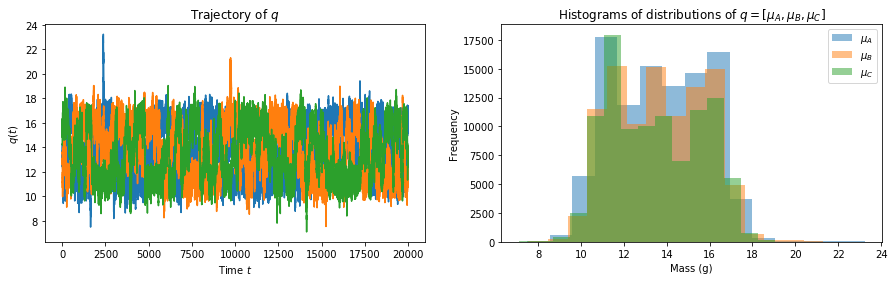

In [38]:
Nsteps = 100000
h = 0.2

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj_noise, p_traj, t_traj = run_simulation_with_noise(q0, p0, Nsteps , h, HMC_with_noise, Y, 1)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj_noise )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj_noise[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj_noise[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj_noise[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

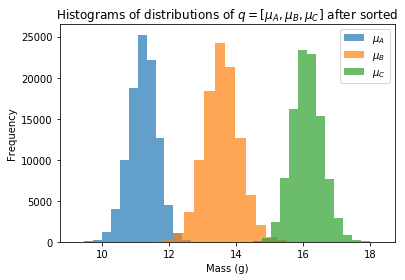

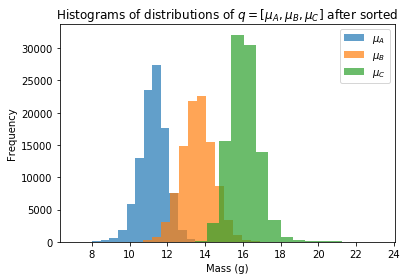

In [39]:

n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    


n = q_traj.shape[0]  # get number of time steps
q_traj_sorted = q_traj_noise.copy()

for k in range(n):
    q_traj_sorted[k] = np.sort(q_traj_noise[k])
    
plt.hist(q_traj_sorted[:,0], bins=15,label='$\mu_A$', alpha=0.7)
plt.hist(q_traj_sorted[:,1], bins=15, label='$\mu_B$',alpha=0.7)
plt.hist(q_traj_sorted[:,2], bins=15, label='$\mu_C$',alpha=0.7)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$ after sorted')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
    

In [97]:
# add in covariance term


# Minibatch size: n


def force_noise_with_cov(q,y_batch,batch_scaling):
    n = len(y_batch)
    m1,m2,m3 = q  
    p_prior = np.exp(-(13.5 - m1)**2/32)*np.exp(-(13.5 - m2)**2/32)*np.exp(-(13.5 - m3)**2/32)
    
    
    
    grad_prior = np.array([-(1/16)*(13.5 - m1), -(1/16)*(13.5 - m2), -(1/16)*(13.5 - m3)])
    
    def likelihood_grad(y):
        m1_vec = m1*np.ones(n)
        m2_vec = m2*np.ones(n)
        m3_vec = m3*np.ones(n)
        p_hat = np.exp(-(y_batch-m1_vec)**2/2) + np.exp(-(y_batch-m2_vec)**2/2) + np.exp(-(y_batch-m3_vec)**2/2)
        
        grad1 = -(y_batch - m1_vec)*np.exp(-(y_batch - m1_vec)**2/2)/p_hat
        grad2 = -(y_batch - m2_vec)*np.exp(-(y_batch - m2_vec)**2/2)/p_hat
        grad3 = -(y_batch - m3_vec)*np.exp(-(y_batch - m3_vec)**2/2)/p_hat
        
        grad = np.array([grad1,grad2,grad3])
        
        return grad
    
    # Take the negative of each gradient
    grad_m1 = -(grad_prior[0] + batch_scaling*sum(likelihood_grad(y_batch)[0]))  
    grad_m2 = -(grad_prior[1] + batch_scaling*sum(likelihood_grad(y_batch)[1]))
    grad_m3 = -(grad_prior[2] + batch_scaling*sum(likelihood_grad(y_batch)[2]))
    
    s_ti = np.zeros([3,n])
    for i in range(n):
        s_ti[i] = (1/n)*grad_prior + likelihood_grad(y_batch[i])
        
        
    B_hat = batch_scaling**2 * np.cov(s_ti)   # covariance of the scores s_ti to estimate covariance matrix
    
    grad = np.array([grad_m1, grad_m2, grad_m3])
    
    return grad, B_hat


def SGHMC(q0,h,y,n):
    # n is the size of the batch
    batch_scaling = len(y)/n
    q = q0
    p = np.random.randn(3)
    current_p = p
    M = np.eye(3)   # preconditioning matrix set to identity. can be used to precondition sampler 
    # when we have more info about target distribution
    
    
    (y_batch, y_updated) = get_minibatch(y,n)
    
    grad, B_hat = force_noise_with_cov(q,y_batch, batch_scaling)
    # for now set C=B_hat and B=zeros(3)
    C = B_hat
    B = np.zeros([3,3])
    added_noise = np.random.multivariate_normal(np.zeros(3), 2*(C-B)*h, 1)
    
    q = q + h*M*p
    p = p + h*grad - C*M*p + added_noise
    
    return q, y_updated
    

In [98]:
n=3
C = np.array([2,2,3])
B = np.zeros((3,3))
h=.1
np.random.multivariate_normal(np.zeros(n), 2*(C-B)*h, 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


array([[1.00012681, 1.0001268 , 1.5001902 ]])

In [99]:
def run_simulation_sghmc( q0,p0, Nsteps, h, step_function, Y, batch_size):
    
    num_scans = len(Y)/batch_size
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 
    y_updated = Y
    scans = num_scans
    for n in range(Nsteps):
        if scans == 0:
            scans = num_scans
            y_updated = Y
        q,y_updated = step_function(q, h, y_updated, batch_size)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t]
        scans = scans - 1

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj

In [100]:
Nsteps = 100000
h = 0.2

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj_noise, p_traj, t_traj = run_simulation_sghmc(q0, p0, Nsteps , h, SGHMC, Y, 1)


fig = plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.plot( t_traj, q_traj_noise )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,2,2)
plt.hist(q_traj_noise[:,0], bins=15,label='$\mu_A$', alpha=0.5)
plt.hist(q_traj_noise[:,1], bins=15, label='$\mu_B$',alpha=0.5)
plt.hist(q_traj_noise[:,2], bins=15, label='$\mu_C$',alpha=0.5)
plt.title('Histograms of distributions of $q = [\mu_A, \mu_B, \mu_C]$')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Degrees of freedom <= 0 for slice
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


LinAlgError: SVD did not converge

NameError: name 'C' is not defined